# Rossmann Sales Prediction

## Practical thesis by Andreas Kosch for Neue Fische GmbH, Hamburg 

## Data Science Bootcamp, 08-11/2018

In [1]:
%%html
<img src="plot.png",width=1000>

### Introduction

The following text is a practical approach to the concrete application of machine learning techniques for sales prediction. The task is to predict sales for Rossmann stores on the basis of historical sales and other data concerning the stores, promotion and other possibly influencing factors. The forecast is needed for capacity and personnel planning to be done in advance for the individual branches. The data were provided during a kaggle challenge, that took place in 2015.


After a short description of the data provided and some examination of the actual data by indicators and visuals, the data will be transformed and fitted to some simple machine learning models, serving as a starting point to further optimizations with respect to the data (feature engineering), the model parameters and the models itself as a continously looping cycle. Furthermore it is intended to draw conclusion about the importance of potentially influencing factors and to derive insights about dependencies of features from the data. 

### Description of dataset: 

The data set was made availa during a kaggle challenge in the year 2015 and is still available for download:

https://www.kaggle.com/c/rossmann-store-sales/data

It consists of train and test data, a stores.csv and a form for submission of forecated results. I will only use train and store data in this context and take the most recent portion of the train data as test data to obtain the true values of sales figures needed for calculating the error measures.

### train.csv

It contains 1017208 samples for 1115 stores(Id of store given in the 'Store' column) for dates between the 1st of January 2013 and the 31st of July 2015. The weekdays of each day are given in the 'DayOfWeek'-Column, digits 1 to 7 representing Monday to Sunday. Sales are the actual sales figures of that particular branch and customers the coressponding number of clients on that day. Open is 1 for days when the branch was opened and 0 when closed, a few of the 1115 stores are open on sundays on a regular basis. Promo indicates whether a store is running a promo on that day.

StateHoliday indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. The encoding can be read as: 
a = public holiday, 
b = Easter holiday, 
c = Christmas, 
0 = None

SchoolHoliday indicates if there were public school holidays for that branch on that day. (Note that Germanys public school holidays are different for regions, so this may probaly differ for stores in different regions.)

Sales is the variable to be predicted for a period of 6 weeks or 42 days in advance. Customers is not a usable input feature for a forecast, since the number of customers is just as unknown as the sales figure. 

In the original challenge, the test.csv was missing the sales and the customer data columns. In the scope of this paper, I will use the last section of training data as test data simply for the fact that i don't have acces to the true values, but need those to calculate error measures for evaluation of model and feature engineering. 

See head and tail of the train data for an illustration.

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

def convert2day(date_string):
    return datetime.strptime(date_string,'%Y-%m-%d').day


def convert2month(date_string):
    return datetime.strptime(date_string,'%Y-%m-%d').month


def convert2year(date_string):
    return datetime.strptime(date_string,'%Y-%m-%d').year


def convert2timestamp(date_string):
    return datetime.strptime(date_string,'%Y-%m-%d').timestamp()

In [3]:
rawdata = pd.read_csv('../data/train.csv', sep=',', low_memory=False)
rawdata.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
rawdata.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


The Date column will be transformed into a more practical format of individual Day, Month, Year Columns for better fitting to possible cyclic patterns in the data. A further Timestamp feature is still maintained to have a continous and numerical value for time for general trends und to keep the possibility of further time-based analysis.

In [5]:
rawdata['Day'] = rawdata['Date'].apply(convert2day)
rawdata['Month'] = rawdata['Date'].apply(convert2month)
rawdata['Year'] = rawdata['Date'].apply(convert2year)
rawdata['Timestamp'] = rawdata['Date'].apply(convert2timestamp)

rawdata = rawdata.drop(columns='Date')

In [6]:
rawdata.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,Timestamp
0,1,5,5263,555,1,1,0,1,31,7,2015,1.438294e+09
1,2,5,6064,625,1,1,0,1,31,7,2015,1.438294e+09
2,3,5,8314,821,1,1,0,1,31,7,2015,1.438294e+09
3,4,5,13995,1498,1,1,0,1,31,7,2015,1.438294e+09
4,5,5,4822,559,1,1,0,1,31,7,2015,1.438294e+09


## Looking at the data...

In [7]:
#Using bokeh library for plotting:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row
from bokeh.palettes import Blues7
from bokeh.palettes import Reds7
from bokeh.palettes import Greens7
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
from bokeh.layouts import row
from bokeh.models import ColumnDataSource
from bokeh.models import NumeralTickFormatter
from bokeh.models.glyphs import Step
output_notebook()

Loading BokehJS ...

### Years

In [8]:
#Mean Sales by Year
year_abs = []
year_count = []
year_mean = []
for i in range (1,4):
    year_abs.append(rawdata[(rawdata.loc[:,'Year'] == 2012 + i)].loc[:,'Sales'].sum())
    year_count.append(rawdata[(rawdata.loc[:,'Year'] == 2012 + i)].loc[:,'Sales'].count())
    year_mean.append(rawdata[(rawdata.loc[:,'Year'] == 2012 + i)].loc[:,'Sales'].mean())

In [9]:
years = ['2013', '2014', '2015']
values1 = year_abs
values2 = year_count
values3 = year_mean 

source1 = ColumnDataSource(data=dict(years=years, values=values1))
source2 = ColumnDataSource(data=dict(years=years, values=values2))
source3 = ColumnDataSource(data=dict(years=years, values=values3))

p = figure(x_range=years, plot_height=250, plot_width = 350, toolbar_location=None, title="Sales - absolute")
p.vbar(x='years', top='values', width=0.7, source=source1,
       line_color='white', fill_color=factor_cmap('years', palette=Reds7, factors=years))
p.xgrid.grid_line_color = None
p.y_range.start = 0
p.legend.orientation = "horizontal"
p.legend.location = "top_right"
p.yaxis[0].formatter = NumeralTickFormatter(format="0")


p2 = figure(x_range=years, plot_height=250, plot_width = 320, toolbar_location=None, title="Sales - Number of datapoints")
p2.vbar(x='years', top='values', width=0.7, source=source2,line_color='white', fill_color=factor_cmap('years', palette=Blues7, factors=years))
p2.y_range.start = 0
p2.yaxis[0].formatter = NumeralTickFormatter(format="0")

p3 = figure(x_range=years, plot_height=250, plot_width = 300, toolbar_location=None, title="Sales per branch per day - mean")
p3.vbar(x='years', top='values', width=0.7, source=source3,line_color='white',
        fill_color=factor_cmap('years', palette=Greens7, factors=years))
p3.y_range.start = 0
p3.yaxis[0].formatter = NumeralTickFormatter(format="0")

In [10]:
show(row(p, p2, p3))

So, although the absolute sales figures are declining, the mean of sales of shops is not, but instead slightly growing from year to year. This can be explained by missing datapoints in 2014 and only part of 2015 being in the test set. It is stated in the data description: Note that some stores in the dataset were temporarily closed for refurbishment. 

In [11]:
rawdata['Timestamp'].hist(figsize =(15,10), bins = 1000);

### Over the course of the year

The purpose here is to see if there is some regularity over the course of a year.

In [12]:
#sales by month
year = []
for i in range (1,13):
    year.append(rawdata[(rawdata.loc[:,'Month'] == i)].loc[:,'Sales'].mean())
year

[5465.395529153085,
 5645.253149690369,
 5784.57887072665,
 5738.866915794719,
 5489.639972997734,
 5760.9643746885895,
 6064.915711155277,
 5693.016553894571,
 5570.246032520326,
 5537.037419354839,
 6008.111821138212,
 6826.611376868607]

In [13]:
x = [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]
y = year
source = ColumnDataSource(dict(x=x, y=y))

# create a new plot with a title and axis labels
p = figure(title="simple line example", x_axis_label='x', y_axis_label='y', plot_height=400, plot_width = 500)
p.y_range.start = 5000
p.y_range.end = 7000
p.x_range.start = 0
p.x_range.end = 13

glyph = Step(x="x", y="y", line_width = 3, line_color="#0000ff", mode="center")
p.add_glyph(source, glyph)

bokeh.models.renderers.GlyphRenderer(
    id='0418a337-08e1-4048-bc22-a44fe091ac2f',
    data_source=bokeh.models.sources.ColumnDataSource(
        id='6da17cc3-4ada-4812-839a-24e985aa2ed1',
        callback=None,
        data={'x': [1.0,
          2.0,
          3.0,
          4.0,
          5.0,
          6.0,
          7.0,
          8.0,
          9.0,
          10.0,
          11.0,
          12.0],
         'y': [5465.395529153085,
          5645.253149690369,
          5784.57887072665,
          5738.866915794719,
          5489.639972997734,
          5760.9643746885895,
          6064.915711155277,
          5693.016553894571,
          5570.246032520326,
          5537.037419354839,
          6008.111821138212,
          6826.611376868607]},
        js_event_callbacks={},
        js_property_callbacks={},
        name=None,
        selected=bokeh.models.selections.Selection(
            id='a3014b5c-11b3-4e58-9824-572e993029dd',
            indices=[],
            js_event_callbacks={},
            js_property_callbacks={},
            line_indices=[],
            multiline_indices={},
            name=None,
            subscribed_events=[],
            tags=[]),
        selection_policy=bokeh.models.selections.UnionRenderers(
            id='c9b2db2d-b73b-4479-8264-8a1f4277f396',
            js_event_callbacks={},
            js_property_callbacks={},
            name=None,
            subscribed_events=[],
            tags=[]),
        subscribed_events=[],
        tags=[]),
    glyph=bokeh.models.glyphs.Step(
        id='38667de1-0b06-47a9-86d5-941445267815',
        js_event_callbacks={},
        js_property_callbacks={},
        line_alpha={'value': 1.0},
        line_cap='butt',
        line_color={'value': '#0000ff'},
        line_dash=[],
        line_dash_offset=0,
        line_join='miter',
        line_width={'value': 3},
        mode='center',
        name=None,
        subscribed_events=[],
        tags=[],
        x={'field': 'x'},
        y={'field': 'y'}),
    hover_glyph=None,
    js_event_callbacks={},
    js_property_callbacks={},
    level='glyph',
    muted=False,
    muted_glyph=None,
    name=None,
    nonselection_glyph='auto',
    selection_glyph='auto',
    subscribed_events=[],
    tags=[],
    view=bokeh.models.sources.CDSView(
        id='59041afe-d328-4809-8492-39c790c473bd',
        filters=[],
        js_event_callbacks={},
        js_property_callbacks={},
        name=None,
        source=bokeh.models.sources.ColumnDataSource(
            id='6da17cc3-4ada-4812-839a-24e985aa2ed1',
            callback=None,
            data={'x': [1.0,
              2.0,
              3.0,
              4.0,
              5.0,
              6.0,
              7.0,
              8.0,
              9.0,
              10.0,
              11.0,
              12.0],
             'y': [5465.395529153085,
              5645.253149690369,
              5784.57887072665,
              5738.866915794719,
              5489.639972997734,
              5760.9643746885895,
              6064.915711155277,
              5693.016553894571,
              5570.246032520326,
              5537.037419354839,
              6008.111821138212,
              6826.611376868607]},
            js_event_callbacks={},
            js_property_callbacks={},
            name=None,
            selected=bokeh.models.selections.Selection(
                id='a3014b5c-11b3-4e58-9824-572e993029dd',
                indices=[],
                js_event_callbacks={},
                js_property_callbacks={},
                line_indices=[],
                multiline_indices={},
                name=None,
                subscribed_events=[],
                tags=[]),
            selection_policy=bokeh.models.selections.UnionRenderers(
                id='c9b2db2d-b73b-4479-8264-8a1f4277f396',
                js_event_callbacks={},
                js_property_callbacks={},
                name=None,
                subscribed_events=[],
 

In [14]:
show(p)

We can see a small peak in July and a strong lift in sales towards the end of the year, probably due to holiday and christmas effects (just speculation). 

### Month

The purpose here is to see if there is some regularity over the course of a month.

In [15]:
#Sales per Day
month = []
for i in range (1,32):
    month.append(rawdata[(rawdata.loc[:,'Day'] == i)].loc[:,'Sales'].mean())
month

[4658.450603273205,
 6973.664894728983,
 5811.044109302673,
 6818.008361953113,
 6357.150246378976,
 5886.054621472301,
 6014.0506794086905,
 5665.783783783784,
 5253.768164849933,
 5406.580946692549,
 5476.275615947439,
 5203.584321337912,
 5741.5176048977155,
 5381.0103031208,
 5831.355980289682,
 6378.7686725399435,
 6124.26134089891,
 6370.260325518889,
 5826.518112587726,
 5839.835986262506,
 5454.107988651635,
 5470.293743467224,
 5674.454263102882,
 4975.415350156786,
 4823.639808869643,
 4837.208541137823,
 5801.54932059131,
 5881.8216216216215,
 5876.384837425348,
 7297.266655607166,
 6235.653178294574]

In [16]:
# prepare some data
x = [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31.]
y = month
source = ColumnDataSource(dict(x=x, y=y))
# create a new plot with a title and axis labels
p = figure(title="simple line example", x_axis_label='x', y_axis_label='y', plot_height=400, plot_width = 500)
p.y_range.start = 4000
p.y_range.end = 8000
glyph = Step(x="x", y="y", line_width = 3, line_color="#0000ff", mode="center")
p.add_glyph(source, glyph)

bokeh.models.renderers.GlyphRenderer(
    id='8b17d5a1-7afe-4db9-b216-aa3ca68fb4c0',
    data_source=bokeh.models.sources.ColumnDataSource(
        id='b15e7ae0-3816-4c34-b919-330dde087560',
        callback=None,
        data={'x': [1.0,
          2.0,
          3.0,
          4.0,
          5.0,
          6.0,
          7.0,
          8.0,
          9.0,
          10.0,
          11.0,
          12.0,
          13.0,
          14.0,
          15.0,
          16.0,
          17.0,
          18.0,
          19.0,
          20.0,
          21.0,
          22.0,
          23.0,
          24.0,
          25.0,
          26.0,
          27.0,
          28.0,
          29.0,
          30.0,
          31.0],
         'y': [4658.450603273205,
          6973.664894728983,
          5811.044109302673,
          6818.008361953113,
          6357.150246378976,
          5886.054621472301,
          6014.0506794086905,
          5665.783783783784,
          5253.768164849933,
          5406.580946692549,
          5476.275615947439,
          5203.584321337912,
          5741.5176048977155,
          5381.0103031208,
          5831.355980289682,
          6378.7686725399435,
          6124.26134089891,
          6370.260325518889,
          5826.518112587726,
          5839.835986262506,
          5454.107988651635,
          5470.293743467224,
          5674.454263102882,
          4975.415350156786,
          4823.639808869643,
          4837.208541137823,
          5801.54932059131,
          5881.8216216216215,
          5876.384837425348,
          7297.266655607166,
          6235.653178294574]},
        js_event_callbacks={},
        js_property_callbacks={},
        name=None,
        selected=bokeh.models.selections.Selection(
            id='d6c8ed48-ce31-4bce-9de9-aea6f4356015',
            indices=[],
            js_event_callbacks={},
            js_property_callbacks={},
            line_indices=[],
            multiline_indices={},
            name=None,
            subscribed_events=[],
            tags=[]),
        selection_policy=bokeh.models.selections.UnionRenderers(
            id='5e5449ee-dc43-4ca1-bde4-70693ae6300b',
            js_event_callbacks={},
            js_property_callbacks={},
            name=None,
            subscribed_events=[],
            tags=[]),
        subscribed_events=[],
        tags=[]),
    glyph=bokeh.models.glyphs.Step(
        id='fcb846a5-53fd-42f1-bca6-2774a2b6579d',
        js_event_callbacks={},
        js_property_callbacks={},
        line_alpha={'value': 1.0},
        line_cap='butt',
        line_color={'value': '#0000ff'},
        line_dash=[],
        line_dash_offset=0,
        line_join='miter',
        line_width={'value': 3},
        mode='center',
        name=None,
        subscribed_events=[],
        tags=[],
        x={'field': 'x'},
        y={'field': 'y'}),
    hover_glyph=None,
    js_event_callbacks={},
    js_property_callbacks={},
    level='glyph',
    muted=False,
    muted_glyph=None,
    name=None,
    nonselection_glyph='auto',
    selection_glyph='auto',
    subscribed_events=[],
    tags=[],
    view=bokeh.models.sources.CDSView(
        id='97d019be-245f-49dc-a35d-e997423e4788',
        filters=[],
        js_event_callbacks={},
        js_property_callbacks={},
        name=None,
        source=bokeh.models.sources.ColumnDataSource(
            id='b15e7ae0-3816-4c34-b919-330dde087560',
            callback=None,
            data={'x': [1.0,
              2.0,
              3.0,
              4.0,
              5.0,
              6.0,
              7.0,
              8.0,
              9.0,
              10.0,
              11.0,
              12.0,
              13.0,
              14.0,
              15.0,
              16.0,
              17.0,
              18.0,
              19.0,
              20.0,
              21.0,
              22.0,
              23.0,
              24.0,
              25.0,
              26.0,
              27.0,
      

In [17]:
show(p)

There are some significant variations in sales over the course of a month and a linear model will probably struggle to cope with that data as it is. So it was probably a good move to separate the datestring into separate values, so that a model can work better with the data, even if the distribiution doesn't seem to provide linearity. 

### Weekdays

In [18]:
#Mean Sales by Weekday (Monday - Sunday:1-7)
weekdays = []
for i in range (1,8):
    weekdays.append(rawdata[(rawdata.loc[:,'DayOfWeek'] == i)].loc[:,'Sales'].mean())
weekdays

[7809.044510467767,
 7005.244466717926,
 6555.884138262451,
 6247.57591278412,
 6723.27430491275,
 5847.562599322877,
 204.18318938713466]

In [19]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
values = weekdays

source = ColumnDataSource(data=dict(days=days, values=values))

p = figure(x_range=days, plot_height=350, toolbar_location=None, title="Sales per weekday")
p.vbar(x='days', top='values', width=0.8, source=source,
       line_color='white', fill_color=factor_cmap('days', palette=Blues7, factors=days))

p.xgrid.grid_line_color = None
#p.y_range.start = 0
p.y_range.end = 10000
p.legend.orientation = "horizontal"
p.legend.location = "top_right"

In [20]:
show(p)

Sales (Mean-Values) are declining over the course of the week, with the exception of Fridays. Sunday Sales are very small, due to the fact that only 33 of 1115 Stores are open on sundays. Looking only at stores that are open on sundays, those stores have a similar distribution over the week with sunday the weakest day, but general higher sales on all days than stores closed on sundays.

In [21]:
#List of store IDs of Stores open on sundays
sunday_stores = rawdata[(rawdata.loc[:,'DayOfWeek'] == 7) & (rawdata.loc[:,'Open'] == 1)]['Store'].unique()
print('IDs of Stores open on Sundays')
print(sunday_stores)
print('Number of Stores open on Sundays:', len(sunday_stores))

IDs of Stores open on Sundays
[  85  122  209  259  262  274  299  310  335  353  423  433  453  494
  512  524  530  562  578  676  682  732  733  769  863  867  931  948
 1045 1081 1097 1099  877]
Number of Stores open on Sundays: 33


In [22]:
sunday_data = rawdata[rawdata['Store'].isin(sunday_stores)]

In [23]:
#Mean Sales by Weekday (Monday - Sunday:1-7)
weekdays2 = []
for i in range (1,8):
    weekdays2.append(sunday_data[(sunday_data.loc[:,'DayOfWeek'] == i)].loc[:,'Sales'].mean())
weekdays2

[9395.382393084623,
 8471.626016260163,
 8216.34620596206,
 8276.237299616167,
 8630.849175886204,
 6960.3130118289355,
 6722.345996360327]

In [24]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
values = weekdays2

source = ColumnDataSource(data=dict(days=days, values=values))

p = figure(x_range=days, plot_height=350, toolbar_location=None, title="Sales per weekday for Shops open on Sundays")
p.vbar(x='days', top='values', width=0.8, source=source,
       line_color='white', fill_color=factor_cmap('days', palette=Blues7, factors=days))

p.xgrid.grid_line_color = None
#p.y_range.start = 0
p.y_range.end = 10000
p.legend.orientation = "horizontal"
p.legend.location = "top_right"

In [25]:
show(p)

In [26]:
rawdata['Sales'].mean()

5773.818972305593

In [27]:
sunday_data['Sales'].mean()

8097.433725972429

The figures above are somewhat misleading since for the mean of sales of stores, the closed days are still in the data. This is true for both groups (sunday generally open or not).

It is probably advisable to eliminate the closed days out of the data, since it is not needed for prediction (a closed shop will produce zero sales) and the simplified data is expected to work better in the model.

### Eliminating closed days:

As expected, closed shops won't generate any sales, as can be shown from the data:

In [28]:
rawdata[(rawdata['Open'] == 0)]['Sales'].mean()

0.0

Surprisingly, there are some cases of zero sales despite the fact of the shop being open:

In [29]:
rawdata[(rawdata['Open'] == 1) & (rawdata['Sales'] == 0)]

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,Timestamp
86825,971,5,0,0,1,0,0,1,15,5,2015,1.431641e+09
142278,674,4,0,0,1,0,0,0,26,3,2015,1.427324e+09
196938,699,4,0,0,1,1,0,0,5,2,2015,1.423091e+09
322053,708,3,0,0,1,1,0,0,1,10,2014,1.412114e+09
330176,357,1,0,0,1,0,0,0,22,9,2014,1.411337e+09
340348,227,4,0,0,1,0,0,0,11,9,2014,1.410386e+09
340860,835,4,0,0,1,0,0,0,11,9,2014,1.410386e+09
341795,835,3,0,0,1,0,0,0,10,9,2014,1.410300e+09
346232,548,5,0,0,1,1,0,1,5,9,2014,1.409868e+09
346734,28,4,0,0,1,1,0,0,4,9,2014,1.409782e+09


In [30]:
len(rawdata[(rawdata['Open'] == 1) & (rawdata['Sales'] == 0)])

54

In [31]:
len(rawdata[(rawdata['Open'] == 1) & (rawdata['Sales'] == 0)]['Store'].unique())

41

These are only 54 occurences of zero sales on open days in the data set for a number of 41 stores. For stores to appear more than once in that list, the days are obviously consecutive. 

It is assumed, that these shops were NOT open on those days for unknown reasons and the 'Open' information for that particular day was entered by mistake. 

In [32]:
rawdata = rawdata[(rawdata['Open'] != 0)]
rawdata = rawdata[(rawdata['Sales'] != 0)]

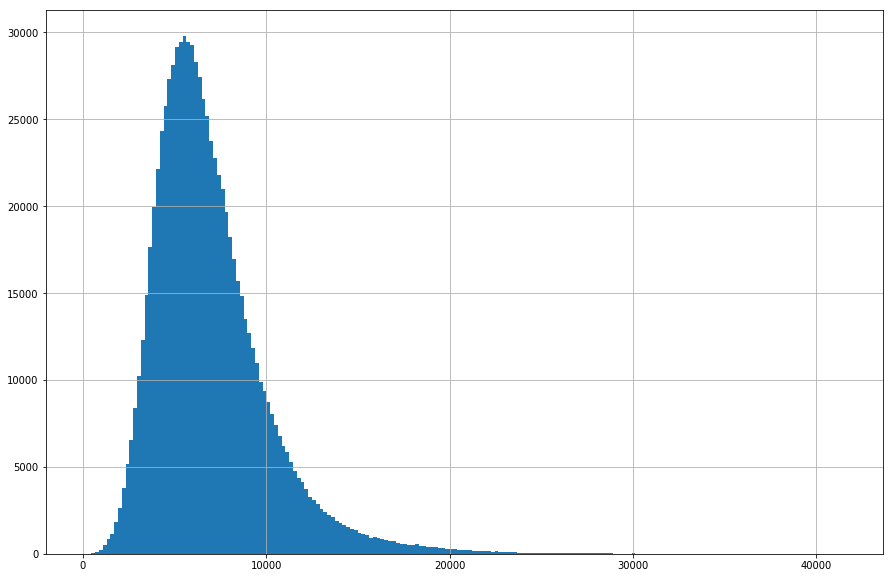

In [33]:
rawdata['Sales'].hist(figsize =(15,10), bins = 200);

In [34]:
# Mean of sales of all stores when closed days are not considered. 
#(compared to 5773.818972305593)
rawdata['Sales'].mean()
 

6955.959133664481

In [35]:
sunday_data = rawdata[rawdata['Store'].isin(sunday_stores)]

In [36]:
# Mean of stores usually open on sundays when closed days are not considered.
#(compared  to 8097.433725972429)
sunday_data['Sales'].mean()

8439.355716694772

### store.csv

Furthermore, we also have a store.csv available, giving general information about the branches.

In [37]:
stores = pd.read_csv('../data/store.csv')
stores.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


Store - a unique Id for each store, later used for joining with the train data.

We are dealing with 4 different StoreTypes: a, b, c, d (no further explanation given) and 3 different assortments, with letters describing an assortment level: a = basic, b = extra, c = extended. 

CompetitionDistance is the distance in meters to the nearest competitor store. CompetitionOpenSinceMonth and CompetitionOpenSinceYear gives the approximate year and month of the time the nearest competitor was opened.

Columns Promo2, Promo2SinceWeek and Pro2Since Year contain the information, if a particular store is taking part in a continuing and consecutive promotion which takes place in certain months, but the actual months when promotions take place do differ from store to store (see PromoInterval). Since the information about promotional activities is already given on a day-to-day basis in the train-data, I will consider this information redundant and omit from modelling for now.


In [38]:
stores = stores.drop(columns = ['Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'])
stores.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear
0,1,c,a,1270.0,9.0,2008.0
1,2,a,a,570.0,11.0,2007.0
2,3,a,a,14130.0,12.0,2006.0
3,4,c,c,620.0,9.0,2009.0
4,5,a,a,29910.0,4.0,2015.0


Having the month and years of Competition open in two columns is considered impractical, these are combined into 'CompetitonOpenSince'.

In [39]:
stores['CompetitionOpenSince'] = stores['CompetitionOpenSinceYear'] + ((1/12)*stores['CompetitionOpenSinceMonth']-(1/24))
stores = stores.drop(columns = ['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth'])

In [40]:
stores.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSince
0,1,c,a,1270.0,2008.708333
1,2,a,a,570.0,2007.875000
2,3,a,a,14130.0,2006.958333
3,4,c,c,620.0,2009.708333
4,5,a,a,29910.0,2015.291667


We still have NaN Values in our table:

In [41]:
stores.isnull().sum(axis = 0) 

Store                     0
StoreType                 0
Assortment                0
CompetitionDistance       3
CompetitionOpenSince    354
dtype: int64

NaN Values in 'CompetitonOpenSince' will be filled with the mean of that column. There are 354 missing values in 'CompetitionOpenSince' and 3 is 'CompetitionDistance'.

In [42]:
stores_COS_mean = stores['CompetitionOpenSince'].mean()
stores_CD_mean = stores['CompetitionDistance'].mean()
stores['CompetitionOpenSince'] = stores['CompetitionOpenSince'].fillna(stores_COS_mean)
stores['CompetitionDistance'] = stores['CompetitionDistance'].fillna(stores_CD_mean)


In [43]:
#Checking for Nan Values again:
stores.isnull().sum(axis = 0) 

Store                   0
StoreType               0
Assortment              0
CompetitionDistance     0
CompetitionOpenSince    0
dtype: int64

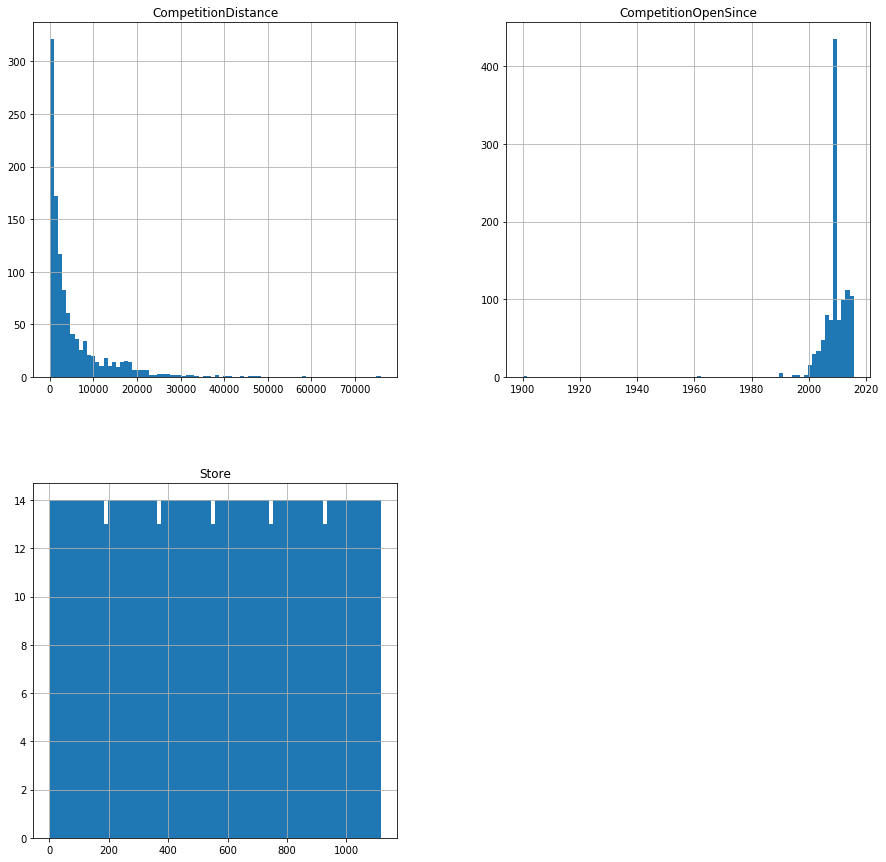

In [44]:
stores.hist(figsize=(15,15), bins = 80);

### Outliers:

The columns 'CompetitionOpenSince' and CompetitionDistance have some outliers in their range, one of the stores claims to have the competition since 1900! A possible feature engineering process would be to set those 'CompetitionOpenSince' values to 1999, if earlier than 1999 (12 stores) and 'CompetitionDistance' to 30001 when > 30000 (19 occurences) and to carefully check, if this is changing the accuracy (for better or worde) by simplifying data or possibly does nothing much at all.

In [45]:
len(stores[stores['CompetitionOpenSince'] < 1999])

12

In [46]:
len(stores[stores['CompetitionDistance'] > 30001])

19

### Eliminating Outliers

In [47]:
stores['CompetitionOpenSince']

0       2008.708333
1       2007.875000
2       2006.958333
3       2009.708333
4       2015.291667
5       2013.958333
6       2013.291667
7       2014.791667
8       2000.625000
9       2009.708333
10      2011.875000
11      2009.229249
12      2009.229249
13      2014.208333
14      2010.208333
15      2009.229249
16      2005.958333
17      2010.458333
18      2009.229249
19      2009.375000
20      1999.791667
21      2009.229249
22      2005.625000
23      2000.208333
24      2003.291667
25      2009.229249
26      2005.041667
27      2014.791667
28      2009.229249
29      2014.125000
           ...     
1085    2013.875000
1086    2011.875000
1087    2009.208333
1088    2009.375000
1089    2009.229249
1090    2009.229249
1091    2000.541667
1092    2009.458333
1093    2013.208333
1094    2007.458333
1095    2009.229249
1096    2002.208333
1097    2004.875000
1098    2013.291667
1099    2009.229249
1100    2012.708333
1101    2012.875000
1102    2006.791667
1103    2012.125000


In [48]:
for i in range (0,1115):
    if stores.loc[i, 'CompetitionOpenSince'] < 1999:
        stores.loc[i, 'CompetitionOpenSince'] = 1999

In [49]:
for i in range (0,1115):
    if stores.loc[i, 'CompetitionDistance'] > 30000:
        stores.loc[i, 'CompetitionDistance'] = 30000

In [50]:
stores[stores['CompetitionOpenSince'] == 1999]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSince
145,146,d,c,8050.0,1999.0
222,223,d,c,2920.0,1999.0
328,329,a,a,1310.0,1999.0
449,450,c,a,5780.0,1999.0
540,541,a,c,650.0,1999.0
570,571,d,a,2110.0,1999.0
706,707,a,c,2900.0,1999.0
814,815,a,a,590.0,1999.0
949,950,a,a,8460.0,1999.0
991,992,a,a,2480.0,1999.0


### Further processing and merging

In [51]:
rawdata = rawdata.merge(stores, on='Store')

In [52]:
rawdata = pd.get_dummies(rawdata, columns=['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment'])

In [53]:
#Export to csv
rawdata.to_csv('../data/preprocessed_data_nb.csv', index = False)

In [54]:
rawdata

,Store,Sales,Customers,Open,Promo,SchoolHoliday,Day,Month,Year,Timestamp,...,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,1,5263,555,1,1,1,31,7,2015,1.438294e+09,...,0,0,0,0,0,1,0,1,0,0
1,1,5020,546,1,1,1,30,7,2015,1.438207e+09,...,0,0,0,0,0,1,0,1,0,0
2,1,4782,523,1,1,1,29,7,2015,1.438121e+09,...,0,0,0,0,0,1,0,1,0,0
3,1,5011,560,1,1,1,28,7,2015,1.438034e+09,...,0,0,0,0,0,1,0,1,0,0
4,1,6102,612,1,1,1,27,7,2015,1.437948e+09,...,0,0,0,0,0,1,0,1,0,0
5,1,4364,500,1,0,0,25,7,2015,1.437775e+09,...,0,0,0,0,0,1,0,1,0,0
6,1,3706,459,1,0,0,24,7,2015,1.437689e+09,...,0,0,0,0,0,1,0,1,0,0
7,1,3769,503,1,0,0,23,7,2015,1.437602e+09,...,0,0,0,0,0,1,0,1,0,0
8,1,3464,463,1,0,0,22,7,2015,1.437516e+09,...,0,0,0,0,0,1,0,1,0,0
9,1,3558,469,1,0,0,21,7,2015,1.437430e+09,...,0,0,0,0,0,1,0,1,0,0


### Splitting up the dataset

Test data are taken from the end of the train data, beginning on the 15th of June 2015. This leaves 6 weeks and 5 days or 47 days until the 31st of July. 

In [55]:
timestamp = rawdata[(rawdata['Day'] == 15) & (rawdata['Month'] == 6) & (rawdata['Year'] == 2015)]['Timestamp'].values[0]
timestamp

1434319200.0

In [56]:
testdata = rawdata[rawdata['Timestamp'] >= timestamp]
traindata = rawdata[rawdata['Timestamp'] < timestamp]

print('Number of samples trainings:', len(traindata))
print('Number of samples test:', len(testdata))

Number of samples trainings: 798486
Number of samples test: 45852


In [57]:
traindata[traindata['Sales'] == 0]

,Store,Sales,Customers,Open,Promo,SchoolHoliday,Day,Month,Year,Timestamp,...,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c


In [58]:
#Check for NaN Values:
rawdata.isnull().sum(axis = 0)

Store                   0
Sales                   0
Customers               0
Open                    0
Promo                   0
SchoolHoliday           0
Day                     0
Month                   0
Year                    0
Timestamp               0
CompetitionDistance     0
CompetitionOpenSince    0
DayOfWeek_1             0
DayOfWeek_2             0
DayOfWeek_3             0
DayOfWeek_4             0
DayOfWeek_5             0
DayOfWeek_6             0
DayOfWeek_7             0
StateHoliday_0          0
StateHoliday_a          0
StateHoliday_b          0
StateHoliday_c          0
StoreType_a             0
StoreType_b             0
StoreType_c             0
StoreType_d             0
Assortment_a            0
Assortment_b            0
Assortment_c            0
dtype: int64

In [59]:
rawdata[rawdata['StoreType_a'] == 1]

,Store,Sales,Customers,Open,Promo,SchoolHoliday,Day,Month,Year,Timestamp,...,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
781,2,6064,625,1,1,1,31,7,2015,1.438294e+09,...,0,0,0,1,0,0,0,1,0,0
782,2,5567,601,1,1,1,30,7,2015,1.438207e+09,...,0,0,0,1,0,0,0,1,0,0
783,2,6402,727,1,1,1,29,7,2015,1.438121e+09,...,0,0,0,1,0,0,0,1,0,0
784,2,5671,646,1,1,1,28,7,2015,1.438034e+09,...,0,0,0,1,0,0,0,1,0,0
785,2,6627,638,1,1,1,27,7,2015,1.437948e+09,...,0,0,0,1,0,0,0,1,0,0
786,2,2512,316,1,0,0,25,7,2015,1.437775e+09,...,0,0,0,1,0,0,0,1,0,0
787,2,3854,468,1,0,1,24,7,2015,1.437689e+09,...,0,0,0,1,0,0,0,1,0,0
788,2,4108,521,1,0,1,23,7,2015,1.437602e+09,...,0,0,0,1,0,0,0,1,0,0
789,2,5093,650,1,0,1,22,7,2015,1.437516e+09,...,0,0,0,1,0,0,0,1,0,0
790,2,3836,532,1,0,1,21,7,2015,1.437430e+09,...,0,0,0,1,0,0,0,1,0,0


### Store Types and Clustering

In [60]:
data = pd.read_csv('../data/preprocessed_data.csv')

In [61]:
data.head(5)

,Store,Sales,Customers,Open,Promo,SchoolHoliday,Day,Month,Year,Timestamp,...,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,1,5263,555,1,1,1,31,7,2015,1.438294e+09,...,0,0,0,0,0,1,0,1,0,0
1,1,5020,546,1,1,1,30,7,2015,1.438207e+09,...,0,0,0,0,0,1,0,1,0,0
2,1,4782,523,1,1,1,29,7,2015,1.438121e+09,...,0,0,0,0,0,1,0,1,0,0
3,1,5011,560,1,1,1,28,7,2015,1.438034e+09,...,0,0,0,0,0,1,0,1,0,0
4,1,6102,612,1,1,1,27,7,2015,1.437948e+09,...,0,0,0,0,0,1,0,1,0,0


In [62]:
data[data['Assortment_a'] == 1]['Sales'].mean()

6621.523057038494

In [63]:
data[data['StoreType_b'] == 1]['Store'].unique()

array([  85,  259,  262,  274,  335,  353,  423,  494,  512,  562,  676,
        682,  733,  769,  948, 1081, 1097])

In [64]:
len(data[(data['StoreType_d'] ==1) & (data['Assortment_c'] == 1)]['Store'].unique())

220

das für alle Kombis a-d und a-c in Tabelle abtragen, Anzahl und Durchschnitts-Sales

In [65]:
storeType = ([len(stores[stores['StoreType'] == 'a']), len(stores[stores['StoreType'] == 'b']), len(stores[stores['StoreType'] == 'c']), len(stores[stores['StoreType'] == 'd'])])
storeType

[602, 17, 148, 348]

In [66]:
stores[stores['StoreType'] == 'a']

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSince
1,2,a,a,570.0,2007.875000
2,3,a,a,14130.0,2006.958333
4,5,a,a,29910.0,2015.291667
5,6,a,a,310.0,2013.958333
6,7,a,c,24000.0,2013.291667
7,8,a,a,7520.0,2014.791667
8,9,a,c,2030.0,2000.625000
9,10,a,a,3160.0,2009.708333
10,11,a,c,960.0,2011.875000
11,12,a,c,1070.0,2009.229249


## New features from previous sales

New features are added to the traindata that are derived from the sales column. The intention is to predict sales figures on previous sales data (single and accumulated sale figures for that store). 

Task: Forecast 1 Week of sales (15.6. - 20.6. 2015) based on the data from the 8.6. - 13.6.2015)

In [67]:
#Timestamp-Values:
np.set_printoptions(suppress=True)
split = traindata[(traindata['Store'] == 1) & (traindata['Day'] == 13) & (traindata['Month'] == 6) & (traindata['Year'] == 2015)]['Timestamp']

In [68]:
np.set_printoptions(suppress=True)
print(split.values)

[1.4341464e+09]


In [69]:
traindata[(traindata['Timestamp'] == split)]

ValueError: Can only compare identically-labeled Series objects

In [ ]:
split.values

In [ ]:
traindata[(traindata['Store'] == 85) & (traindata['Month'] == 6) & (traindata['Year'] == 2015)]

In [ ]:
traindata[traindata['Store'] == 1].iloc[5,1]

In [ ]:
traindata.at[41,'Sales']

In [ ]:
traindata.iat[1,1]

In [ ]:
n_stores = 5
for i in range (1,n_stores):
    new_features = pd.DataFrame()
    new_features = traindata[traindata['Store'] == i]
    n_entries = len(new_features)
    print(n_entries)
    #print(new_features.head())
    
    
    
    

In [ ]:
testdata.tail(100)

In [ ]:
traindata['Timestamp'].unique()

In [ ]:
sales = pd.DataFrame(columns=range(1115),index=range(1000))
for i in range(1,1116):
    sales[i] = pd.Series(traindata[(traindata.loc[:,'Store'] == i)].loc[:,'Sales'].values)
sales = sales.drop(0, axis = 1)
#sales = sales.dropna(axis = 0, how='all')
lesales[85]

In [ ]:
sales

In [ ]:
len(traindata[(traindata['Store'] == 86)])

In [ ]:
rawdata['Timestamp'][0]

In [ ]:
import time
time.ctime(int("1438293600"))






In [ ]:
time.strftime("%D %H:%M", time.localtime(int("1438293600")))